In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
HIGH_PERFORMANCE = False
DYNAMO_DEBUG = False
COMPILE = False
SHOW_ANIMATION = True

In [3]:
%env TORCH_LOGS=dynamo 
%env TORCHDYNAMO_VERBOSE=1

env: TORCH_LOGS=dynamo
env: TORCHDYNAMO_VERBOSE=1


In [4]:
import torch
import matplotlib.pyplot as plt
from flipper_training.configs import (
    WorldConfig,
    RobotModelConfig,
    PhysicsEngineConfig,
)
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *
from collections import deque

In [5]:
from flipper_training.utils.torch_utils import autodevice

device = autodevice(HIGH_PERFORMANCE)

In [6]:
from flipper_training.vis.static_vis import *

In [7]:
torch.random.manual_seed(420)

In [8]:
num_robots = 1

In [9]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing="xy")

In [10]:
# # gaussian hm
z = (
    (
        1.0 * torch.exp(-0.5 * ((x - 0) ** 2 + (y - 4) ** 2))
        + 5.0 * torch.exp(-0.3 * ((x - 1) ** 2 + (y + 2) ** 2))
        + 2.0 * torch.exp(-0.1 * ((x + max_coord) ** 2 + (y + max_coord) ** 2))
    )
    + 0.01 * torch.randn_like(x)
    + torch.exp(-0.03 * ((x + 5) ** 2 + (y + 5) ** 2))
)
# block hm
# z = torch.zeros_like(x)
# for thresh in [1.0, 0, -1.0, -2]:
#     z[torch.logical_and(x > -thresh, y < thresh)] += 0.3

# quadratic hill hm
# z = 1 - 0.01 * ((x-1)**8 + (y+3)**8) + 0.01 * torch.randn_like(x)
# z.clamp_(min=0)
# zero hm
# z = torch.zeros_like(x)
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([1, 128, 128])

In [11]:
from flipper_training.utils.heightmap_generators import *
from flipper_training.utils.environment import make_x_y_grids, generate_heightmaps

# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
heighmap_gen = MultiGaussianHeightmapGenerator(
    min_gaussians=400,
    max_gaussians=600,
    min_height_fraction=0.03,
    max_height_fraction=0.18,
    min_std_fraction=0.03,
    max_std_fraction=0.08,
    min_sigma_ratio=0.6,
)
x_grid, y_grid = make_x_y_grids(max_coord, grid_res, num_robots)
z_grid, suit_mask = generate_heightmaps(x_grid, y_grid, heighmap_gen)

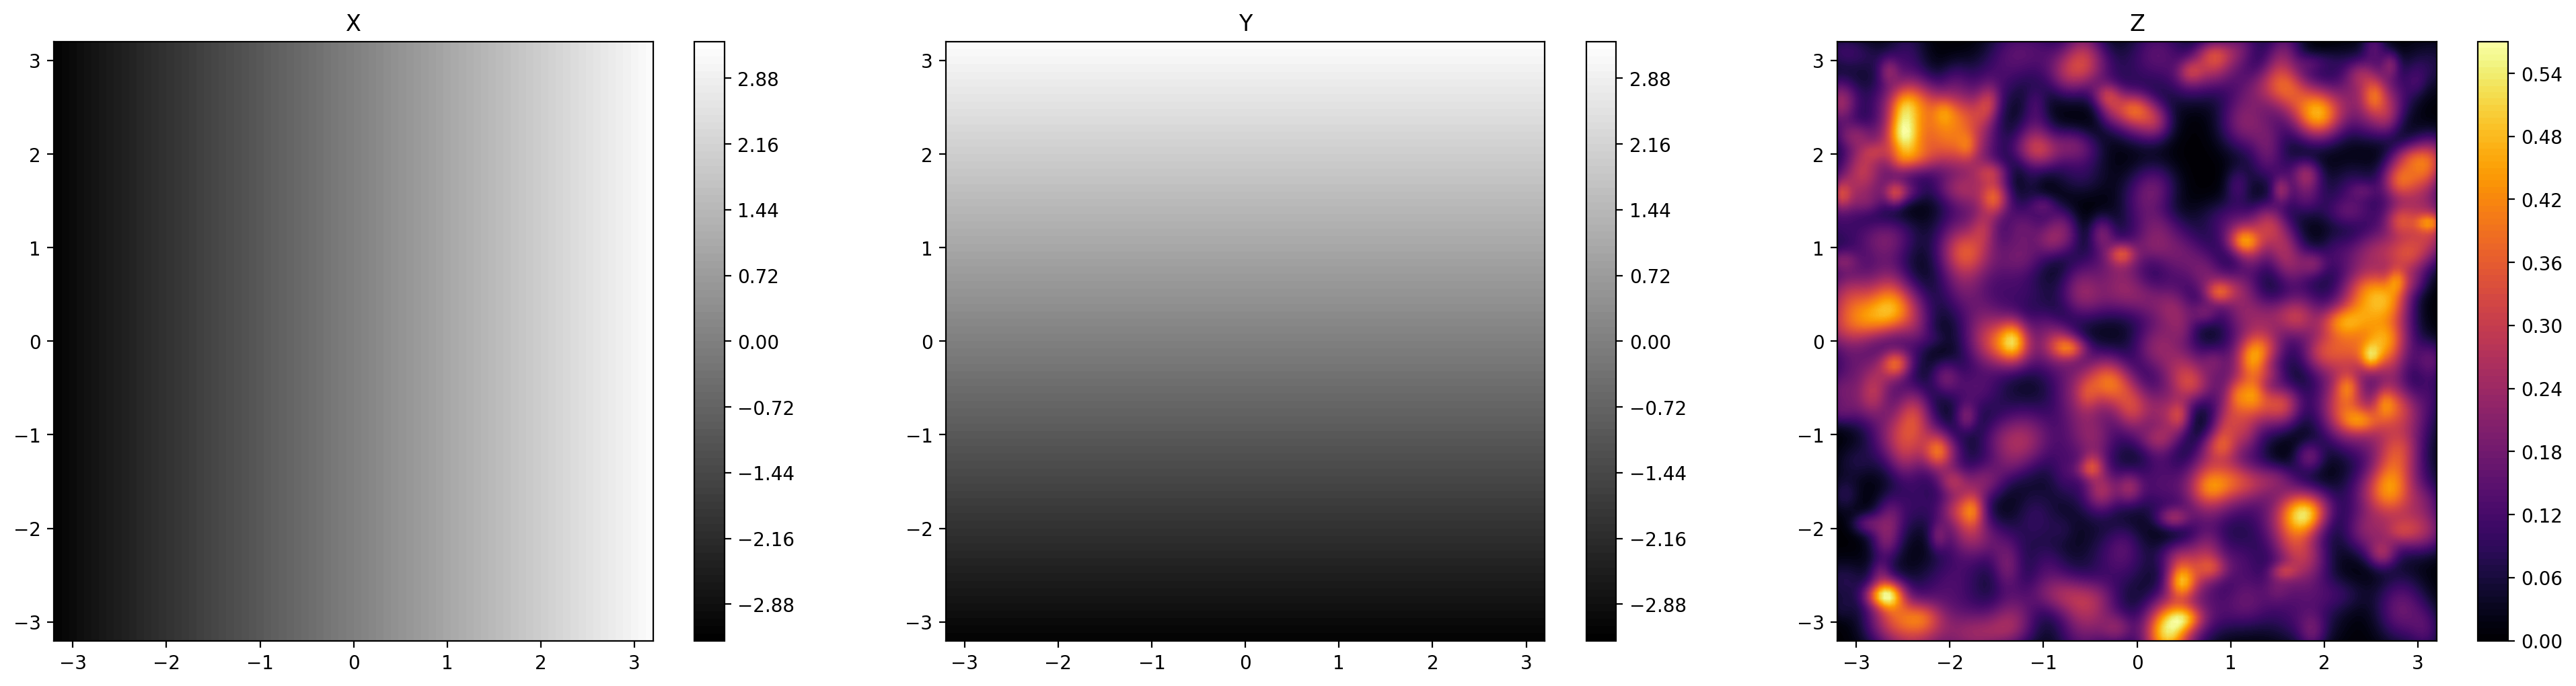

In [12]:
plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [13]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv", points_per_driving_part=256, points_per_body=512)
world_config = WorldConfig(
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=40000,
    k_friction_lat=0.5,
    k_friction_lon=0.8,
)
physics_config = PhysicsEngineConfig(num_robots=num_robots, damping_alpha=1.0, dt=0.01)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_0.010_dp256b_512_whl0.02_trck0.05_6b5c78e6921a37db7bf931f0d2244c93f70b92b02a9b9262da081e7cfc4ab154
driving_direction: torch.Size([3])
body_bbox: torch.Size([6])
driving_part_bboxes: torch.Size([4, 6])
driving_part_masses: torch.Size([4])
joint_positions: torch.Size([4, 3])
joint_limits: torch.Size([2, 4])
joint_max_pivot_vels: torch.Size([4])
driving_part_movable_mask: torch.Size([4])
driving_part_points: torch.Size([4, 256, 3])
driving_part_inertias: torch.Size([4, 3, 3])
driving_part_cogs: torch.Size([4, 3])
body_points: torch.Size([512, 3])
body_inertia: torch.Size([3, 3])
body_cog: torch.Size([3])
thrust_directions: torch.Size([4, 256, 3])
joint_local_driving_part_pts: torch.Size([4, 256, 3])
joint_local_driving_part_cogs: torch.Size([4, 3])
RobotModelConfig for marv
Body mass: 47.8
Total mass: 67.8
Body bbox: tensor([ 0.3000,  0.1900,  0.4500, -0.3000, -0.1900, -0.0500])
N

In [14]:
# Controls
traj_length = 8.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = 0.5  # rad/s yaw
controls = robot_model.vw_to_vels(speed, omega)
flipper_controls = torch.zeros_like(controls)

In [15]:
for cfg in [robot_model, world_config, physics_config]:
    cfg.to(device)

In [16]:
engine = DPhysicsEngine(physics_config, robot_model, device)

In [36]:
from flipper_training.utils.geometry import euler_to_quaternion


x0 = torch.tensor([[-2.5, -2.5, 4.1500]]).to(device).repeat(num_robots, 1)
xd0 = torch.zeros_like(x0)
q0 = euler_to_quaternion(*torch.tensor([0, 0, 0.2 * torch.pi])).to(device).repeat(num_robots, 1)
omega0 = torch.zeros_like(x0)
thetas0 = torch.zeros(num_robots, robot_model.num_driving_parts).to(device)
controls_all = torch.cat((controls, flipper_controls), dim=-1).repeat(n_iters, num_robots, 1).to(device)

In [37]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = torch.pi
periods = traj_length / 10.0
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, robot_model.num_driving_parts] = rot_vels
controls_all[:, :, robot_model.num_driving_parts + 1] = rot_vels
controls_all[:, :, robot_model.num_driving_parts + 2] = -rot_vels
controls_all[:, :, robot_model.num_driving_parts + 3] = -rot_vels

In [38]:
# Set the flippers to an fixed position at the beginning
angles_deg = torch.tensor([-90.0, -90.0, 90.0, 90.0])
angles = torch.deg2rad(angles_deg)
max_joint_vel = robot_model.joint_max_pivot_vels
min_joint_vel = -robot_model.joint_max_pivot_vels
times = (angles >= 0).float() * (angles / max_joint_vel) + (angles < 0).float() * (angles / min_joint_vel)
steps = (times / physics_config.dt).int()
vels = angles / times
vels[torch.isnan(vels)] = 0.0
# controls_all[: steps[0], :, robot_model.num_driving_parts] = vels[0]
# controls_all[: steps[1], :, robot_model.num_driving_parts + 1] = vels[1]
# controls_all[: steps[2], :, robot_model.num_driving_parts + 2] = vels[2]
# controls_all[: steps[3], :, robot_model.num_driving_parts + 3] = vels[3]

In [39]:
init_state = PhysicsState(x0, xd0, q0, omega0, thetas0)

In [40]:
bench_state = init_state.new_zeros()

In [41]:
compile_opts = {"max-autotune": True, "triton.cudagraphs": True, "coordinate_descent_tuning": True}
if DYNAMO_DEBUG:
    compile_opts |= {"trace.enabled": True, "trace.graph_diagram": True}

In [42]:
print(torch._inductor.list_mode_options())
print(torch._inductor.list_options())

{'default': {}, 'reduce-overhead': {'triton.cudagraphs': True}, 'max-autotune-no-cudagraphs': {'max_autotune': True, 'coordinate_descent_tuning': True}, 'max-autotune': {'max_autotune': True, 'triton.cudagraphs': True, 'coordinate_descent_tuning': True}}
['TYPE_CHECKING', 'enable_auto_functionalized_v2', 'debug', 'disable_progress', 'verbose_progress', 'fx_graph_cache', 'fx_graph_remote_cache', 'bundle_triton_into_fx_graph_cache', 'autotune_local_cache', 'autotune_remote_cache', 'bundled_autotune_remote_cache', 'force_disable_caches', 'sleep_sec_TESTING_ONLY', 'custom_op_default_layout_constraint', 'triton_kernel_default_layout_constraint', 'cpp_wrapper', 'c_shim_version', 'dce', 'static_weight_shapes', 'size_asserts', 'nan_asserts', 'pick_loop_orders', 'inplace_buffers', 'allow_buffer_reuse', 'memory_planning', 'memory_pool', 'benchmark_harness', 'epilogue_fusion', 'epilogue_fusion_first', 'pattern_matcher', 'b2b_gemm_pass', 'post_grad_custom_pre_pass', 'post_grad_custom_post_pass', '

In [43]:
if COMPILE:
    # run all torch compilation
    engine = torch.compile(engine, options=compile_opts)
    _ = engine(bench_state, controls_all[0], world_config)

In [44]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [45]:
robot_model._print_tensor_info()

driving_direction: torch.Size([3])
body_bbox: torch.Size([6])
driving_part_bboxes: torch.Size([4, 6])
driving_part_masses: torch.Size([4])
joint_positions: torch.Size([4, 3])
joint_limits: torch.Size([2, 4])
joint_max_pivot_vels: torch.Size([4])
driving_part_movable_mask: torch.Size([4])
driving_part_points: torch.Size([4, 256, 3])
driving_part_inertias: torch.Size([4, 3, 3])
driving_part_cogs: torch.Size([4, 3])
body_points: torch.Size([512, 3])
body_inertia: torch.Size([3, 3])
body_cog: torch.Size([3])
thrust_directions: torch.Size([4, 256, 3])
joint_local_driving_part_pts: torch.Size([4, 256, 3])
joint_local_driving_part_cogs: torch.Size([4, 3])


In [46]:
from flipper_training.engine.engine_state import (
    vectorize_iter_of_states as vectorize_states,
)

In [47]:
%%time 
state = init_state
for i in range(n_iters):
    state, der, aux = engine(state, controls_all[i], world_config)
    states.append(state)
    dstates.append(der)
    auxs.append(aux)

CPU times: user 5.62 s, sys: 994 ms, total: 6.61 s
Wall time: 892 ms


In [48]:
states_vec = vectorize_states(states)
dstates_vec = vectorize_states(dstates)
aux_vec = vectorize_states(auxs)

<Axes: title={'center': 'Birdview of trajectory'}, xlabel='x', ylabel='y'>

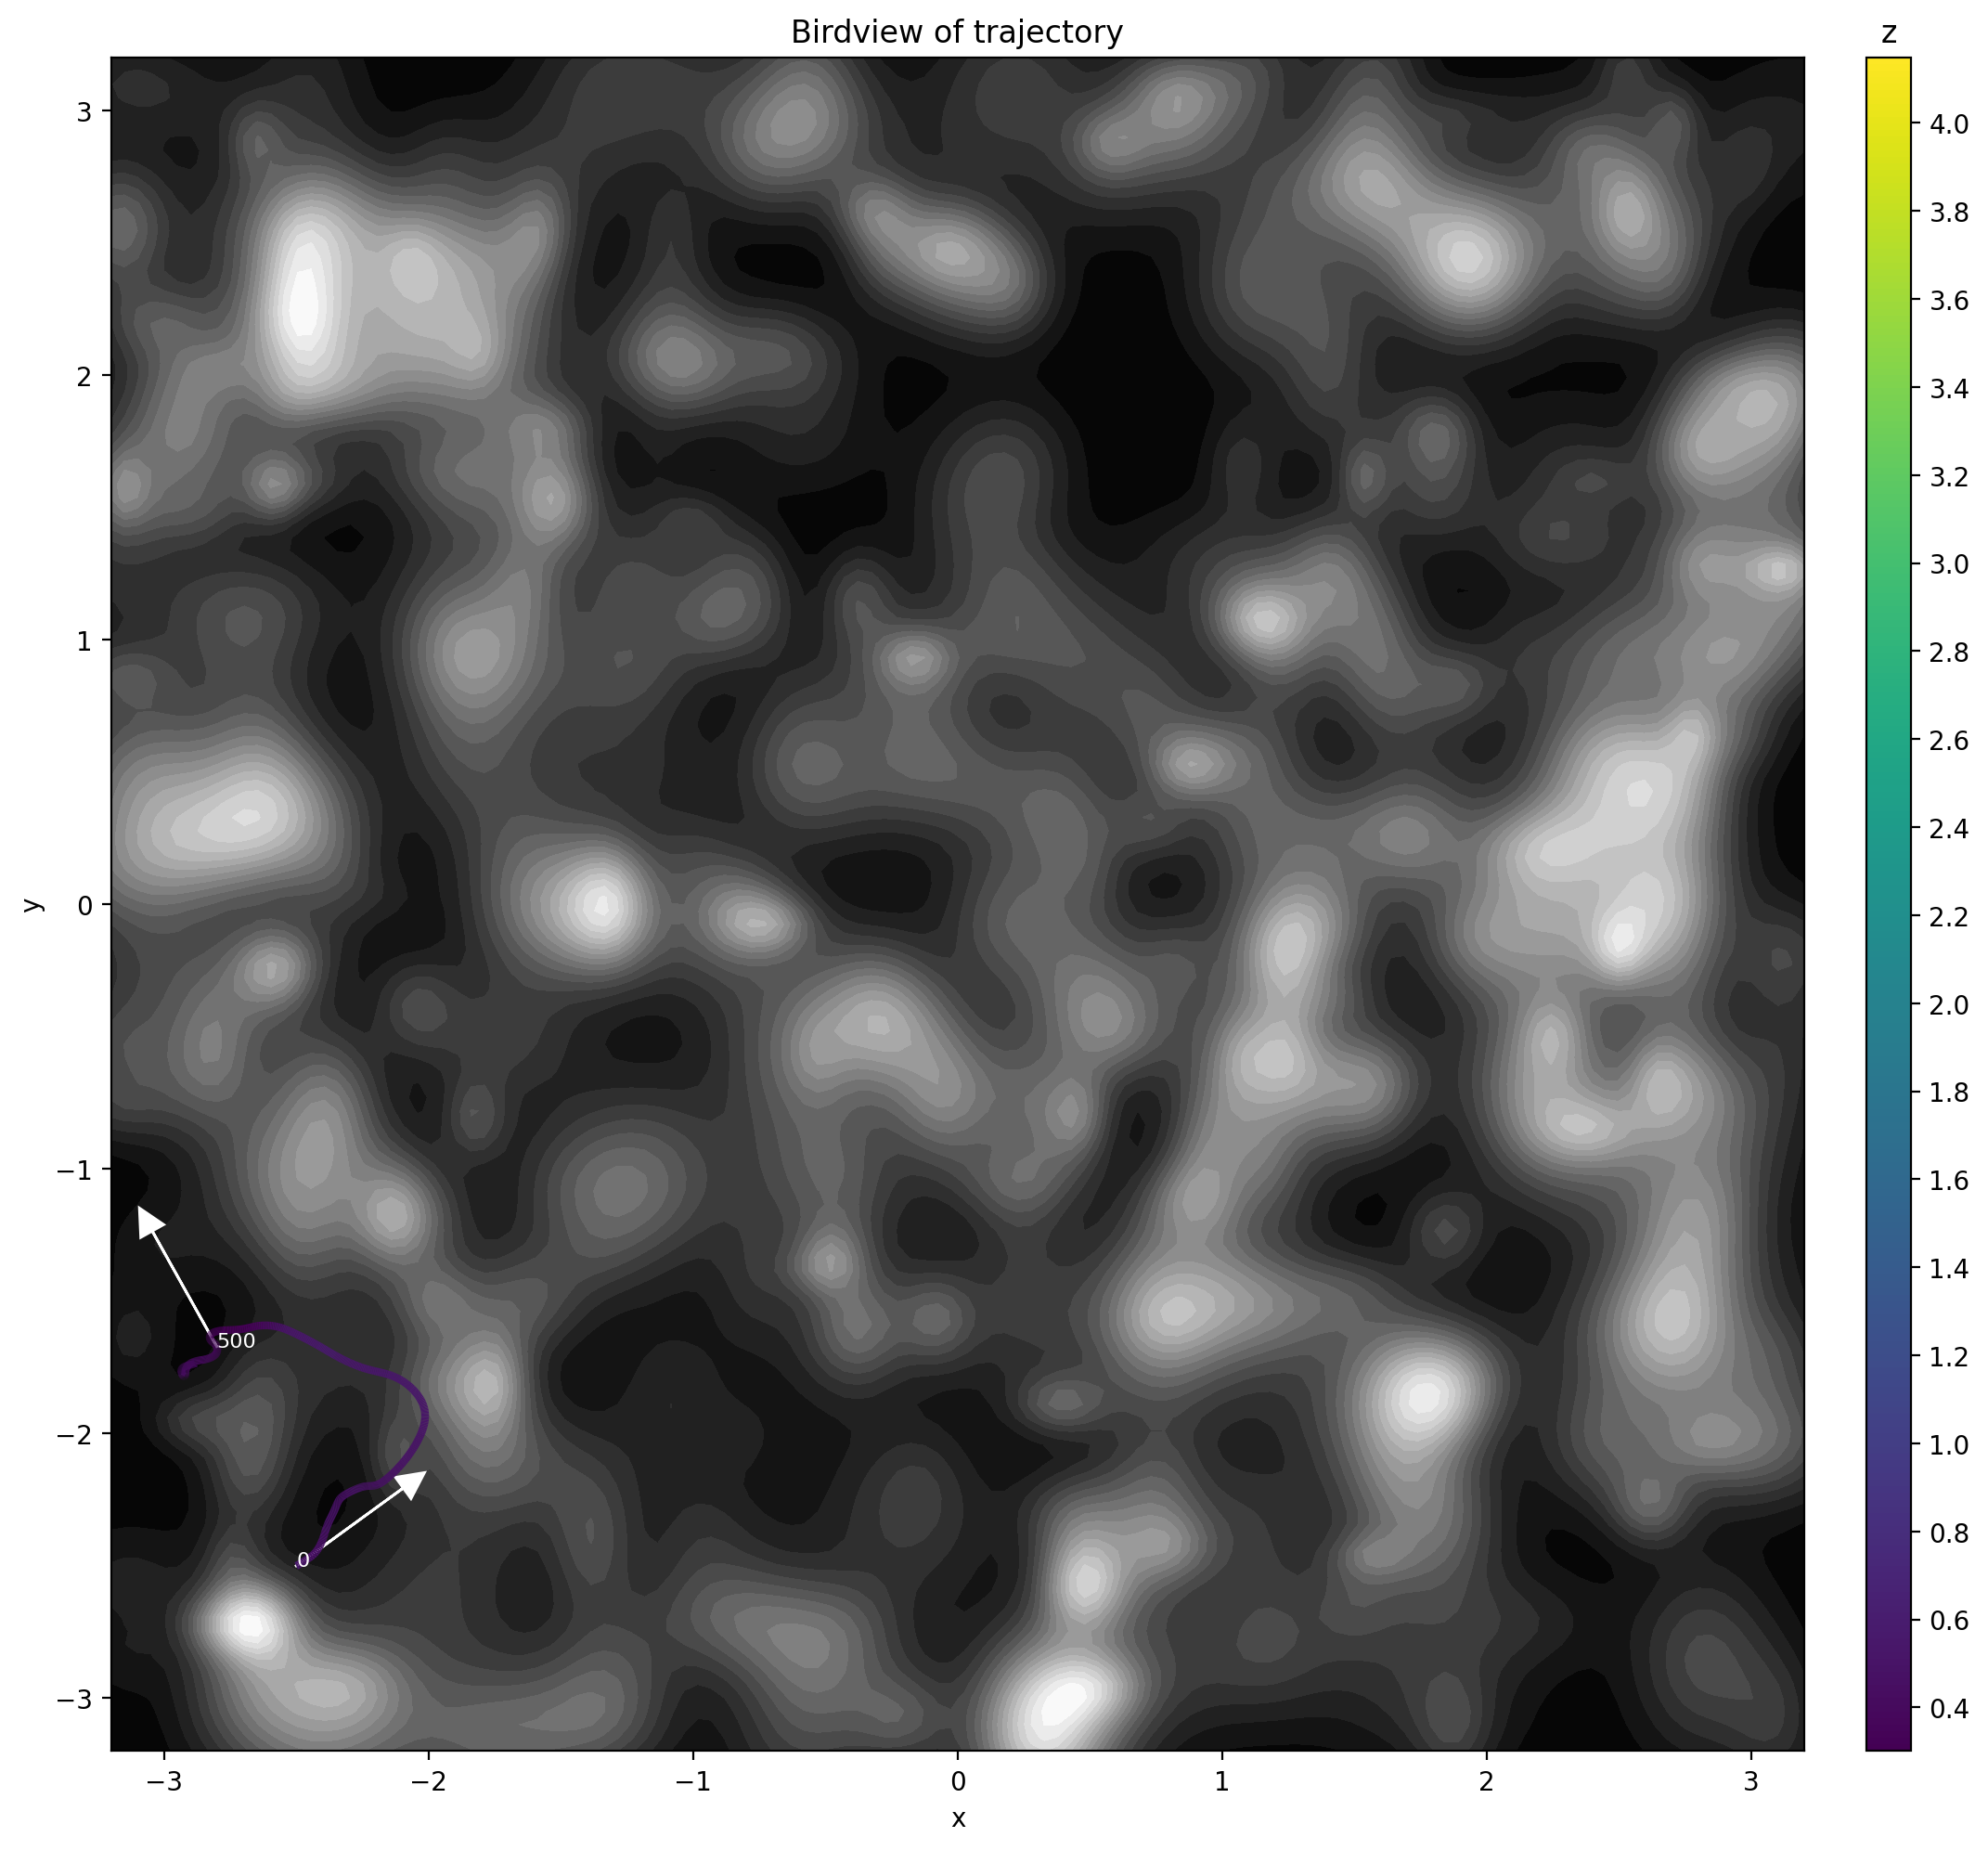

In [49]:
plot_birdview_trajectory(world_config, states, iter_step=500)

In [50]:
ROBOT_IDX = 0

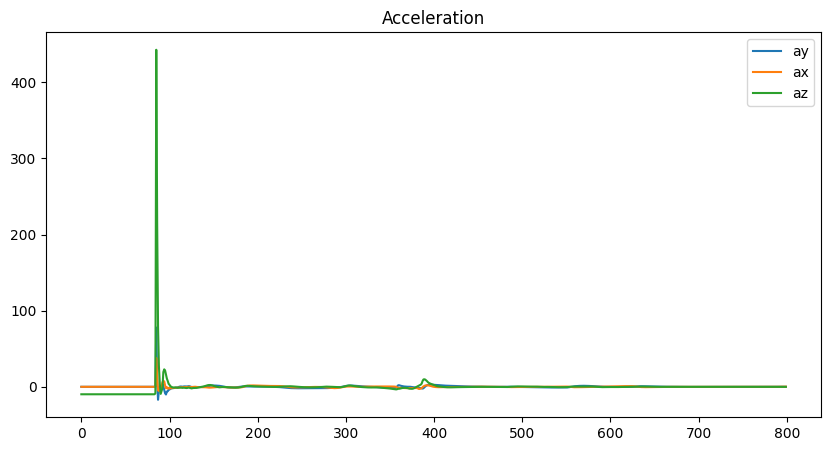

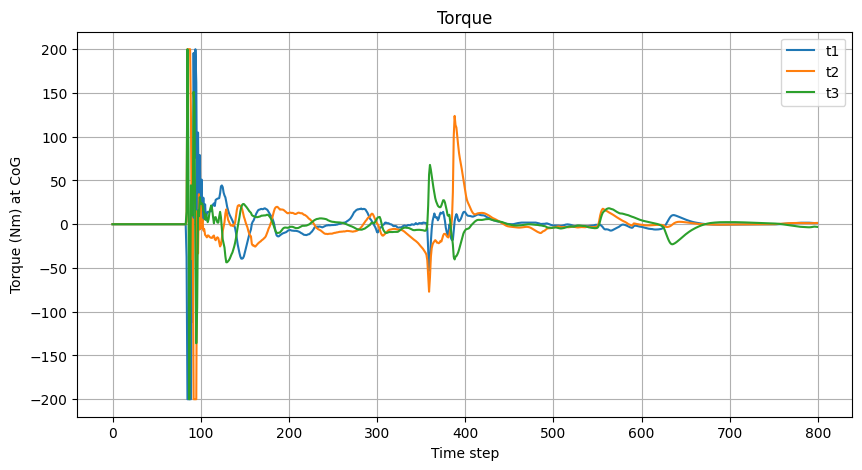

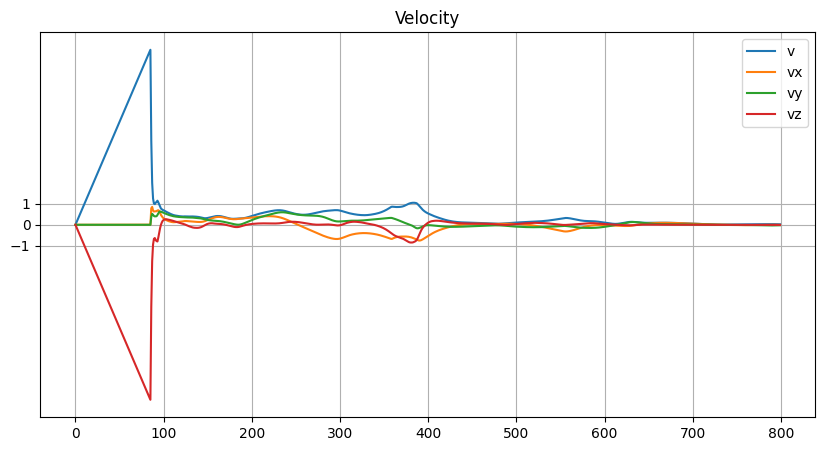

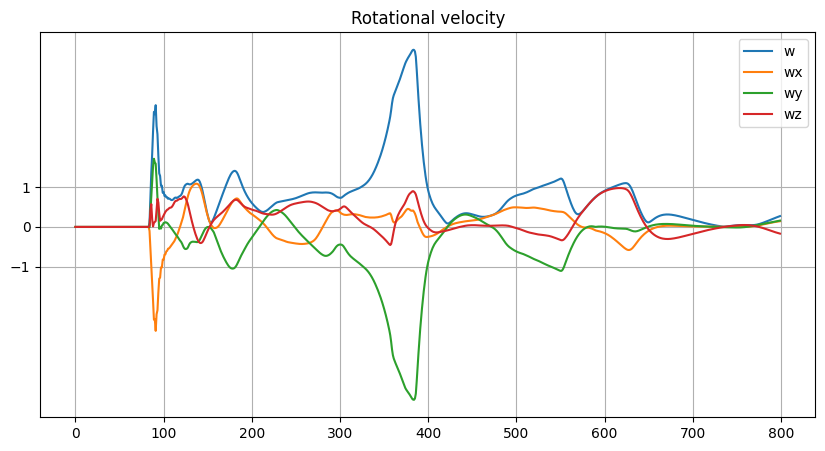

In [51]:
# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Acceleration")
plt.plot(ay, label="ay")
plt.plot(ax, label="ax")
plt.plot(az, label="az")
plt.legend()
plt.show()

# Plot components of torque
t1, t2, t3 = aux_vec.torque[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Torque")
plt.plot(t1, label="t1")
plt.plot(t2, label="t2")
plt.plot(t3, label="t3")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Torque (Nm) at CoG")
plt.legend()
plt.show()

# Plot components of velocity
v = dstates_vec.xd[:, ROBOT_IDX].cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Velocity")
plt.plot((v**2).sum(-1) ** 0.5, label="v")
plt.plot(v[:, 0], label="vx")
plt.plot(v[:, 1], label="vy")
plt.plot(v[:, 2], label="vz")
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid()
plt.show()

# Plot components of rotational velocity
w = states_vec.omega[:, ROBOT_IDX].cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Rotational velocity")
plt.plot((w**2).sum(-1) ** 0.5, label="w")
plt.plot(w[:, 0], label="wx")
plt.plot(w[:, 1], label="wy")
plt.plot(w[:, 2], label="wz")
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid()
plt.show()

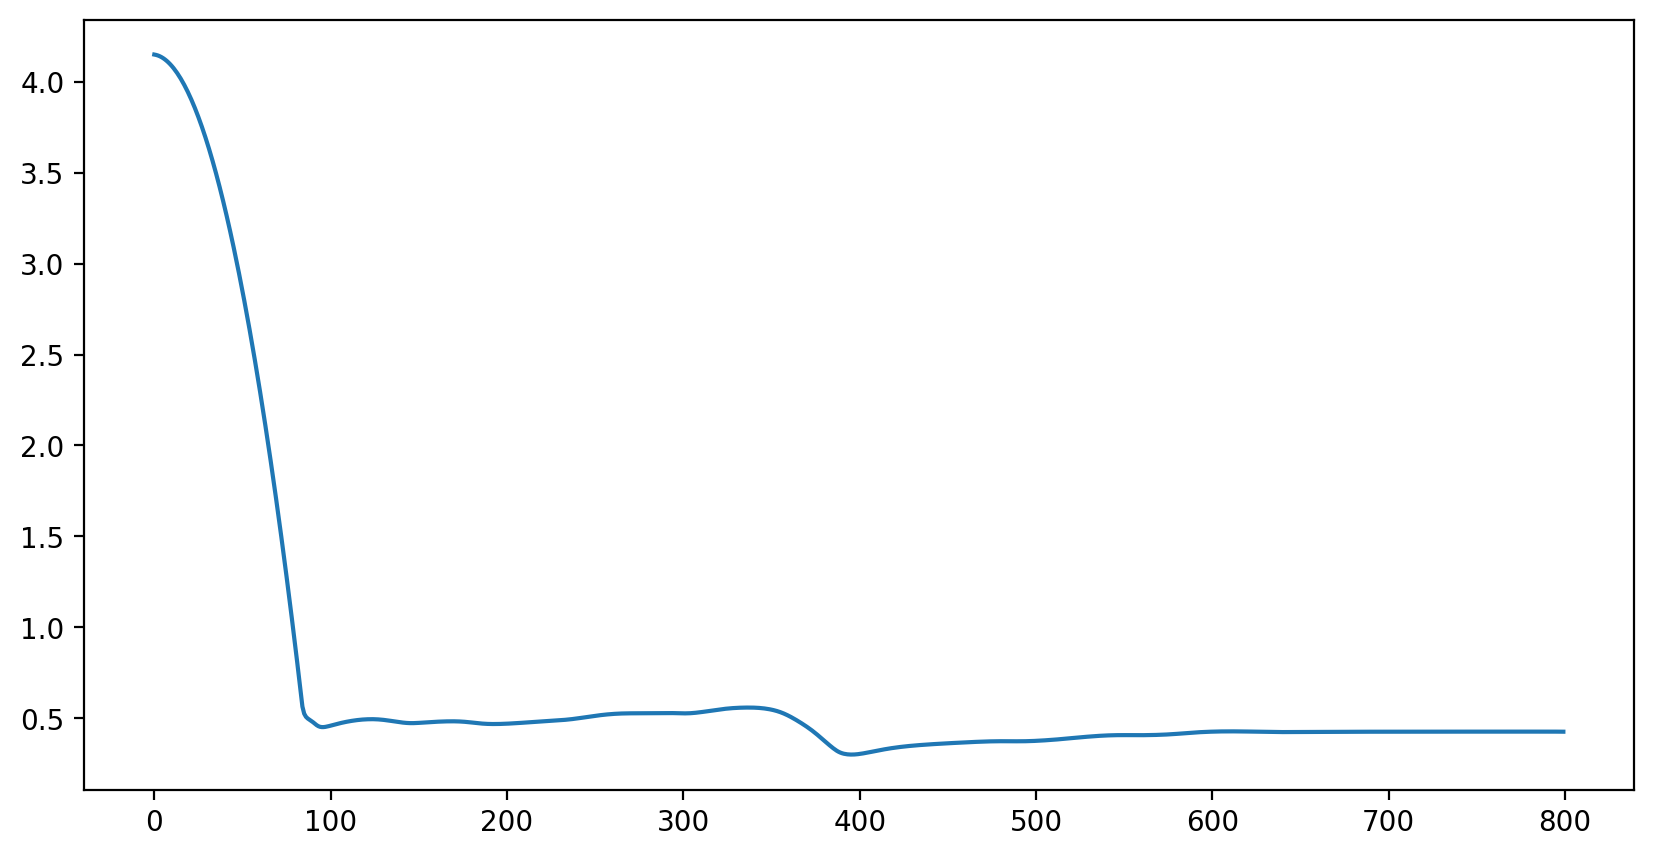

In [52]:
# Height of the robot
plt.figure(figsize=(10, 5), dpi=200)
z = states_vec.x[:, ROBOT_IDX, 2].cpu().numpy()
plt.plot(z)

In [53]:
plot_3d_trajectory(world_config, states, auxs)

In [54]:
if SHOW_ANIMATION:
    from flipper_training.vis.animator import animate_trajectory

    ani = animate_trajectory(
        world_config,
        physics_config,
        states,
        auxs,
        ROBOT_IDX,
        show_xd_points=False,
        show_cog_coords=False,
        show_friction_forces=False,
        show_spring_forces=False,
        show_act_forces=True,
    )